In [1]:
# %%
import torch
import numpy as np
import scvelo as scv
from deepvelo.utils.velocity import velocity
from deepvelo.utils.util import update_dict
from deepvelo.utils.temporal import latent_time
from deepvelo import train, Constants

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2


Using backend: pytorch


# Load Data and preprocess
The Dentate Gyrus neurogenesis data from [La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6).

In [2]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo",
    "loss": {"args": {"coeff_u": 1.0, "coeff_s": 0.75}},
    "trainer": {"epochs": 100, "verbosity": 0},
}
configs = update_dict(Constants.default_configs, configs)


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)


computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
{'name': 'DeepVelo', 'n_gpu': 1, 'arch': {'type': 'VeloGCN', 'args': {'n_genes': 2000, 'layers': [64, 64], 'dropout': 0.2, 'fc_layer': False, 'pred_unspliced': False}}, 'data_loader': {'type': 'VeloDataLoader', 'args': {'basis': 'pca', 'batch_size': 18213, 'shuffle': False, 'validation_split': 0.0, 'num_workers': 2, 'type': 'pca, t', 'topC': 30, 'topG': 20}}, 'online_test': 'velo_mat_E10-12.npz', 'optimizer': {'type': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0, 'amsgrad': True}}, 'loss': {'type': 'mle_plus_direction', 'args': {'pearson_scale': 100.0, 'coeff_u': 1.0, 'coeff_s': 0.75}}, 'constraint_loss': False, 'mask_zeros': False, 'metrics': ['mse'], 'lr_scheduler': {'type': 'StepLR', 'args': {'step_size': 1, 'gamma': 0.97}}, 'trainer': {'epochs': 100, 'save_dir': 'saved/', 'save_period': 1000, 'verbosity': 0, 'monitor': 'min mse', 'guided_epochs': 0, 'ea

INFO:train:VeloGCN(
  (layers): ModuleList(
    (0): GraphConv(in=4000, out=64, normalization=both, activation=<function relu at 0x7f59f2dc3400>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7f59f2dc3400>)
    (2): GraphConv(in=64, out=4000, normalization=both, activation=None)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)
Trainable parameters: 520224


velo data shape: torch.Size([18213, 2000])


mle: 37.329063415527344, direction_loss: 1.0020471811294556
mle: 25.18919563293457, direction_loss: 0.9524794220924377
mle: 23.531291961669922, direction_loss: 0.9181259274482727
mle: 24.657665252685547, direction_loss: 0.8912302851676941
mle: 25.71396255493164, direction_loss: 0.8691807985305786
mle: 26.156787872314453, direction_loss: 0.8509549498558044
mle: 25.36181640625, direction_loss: 0.8355069756507874
mle: 23.85152816772461, direction_loss: 0.8214769959449768
mle: 22.223438262939453, direction_loss: 0.8094761371612549
mle: 21.078279495239258, direction_loss: 0.7987059950828552
mle: 21.00168228149414, direction_loss: 0.7892071604728699
mle: 21.15517807006836, direction_loss: 0.7809067964553833
mle: 21.57560920715332, direction_loss: 0.77382892370224
mle: 21.631364822387695, direction_loss: 0.7673456072807312
mle: 21.84108543395996, direction_loss: 0.761315107345581
mle: 21.48674964904785, direction_loss: 0.7559027075767517
mle: 20.490299224853516, direction_loss: 0.750784456729

In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


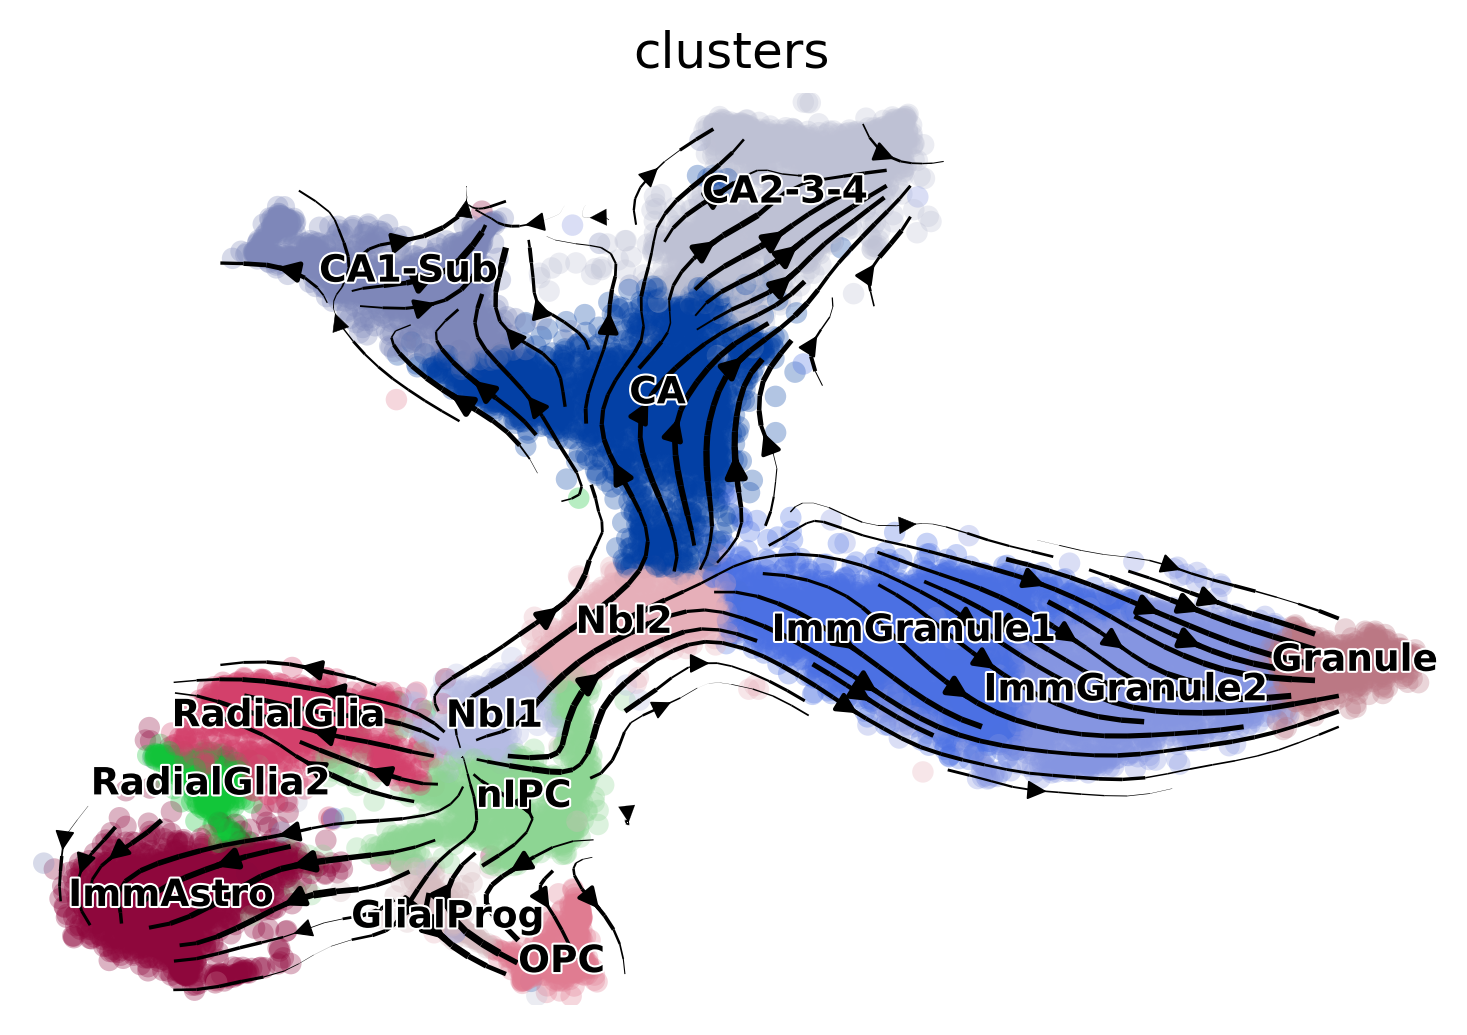

In [7]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


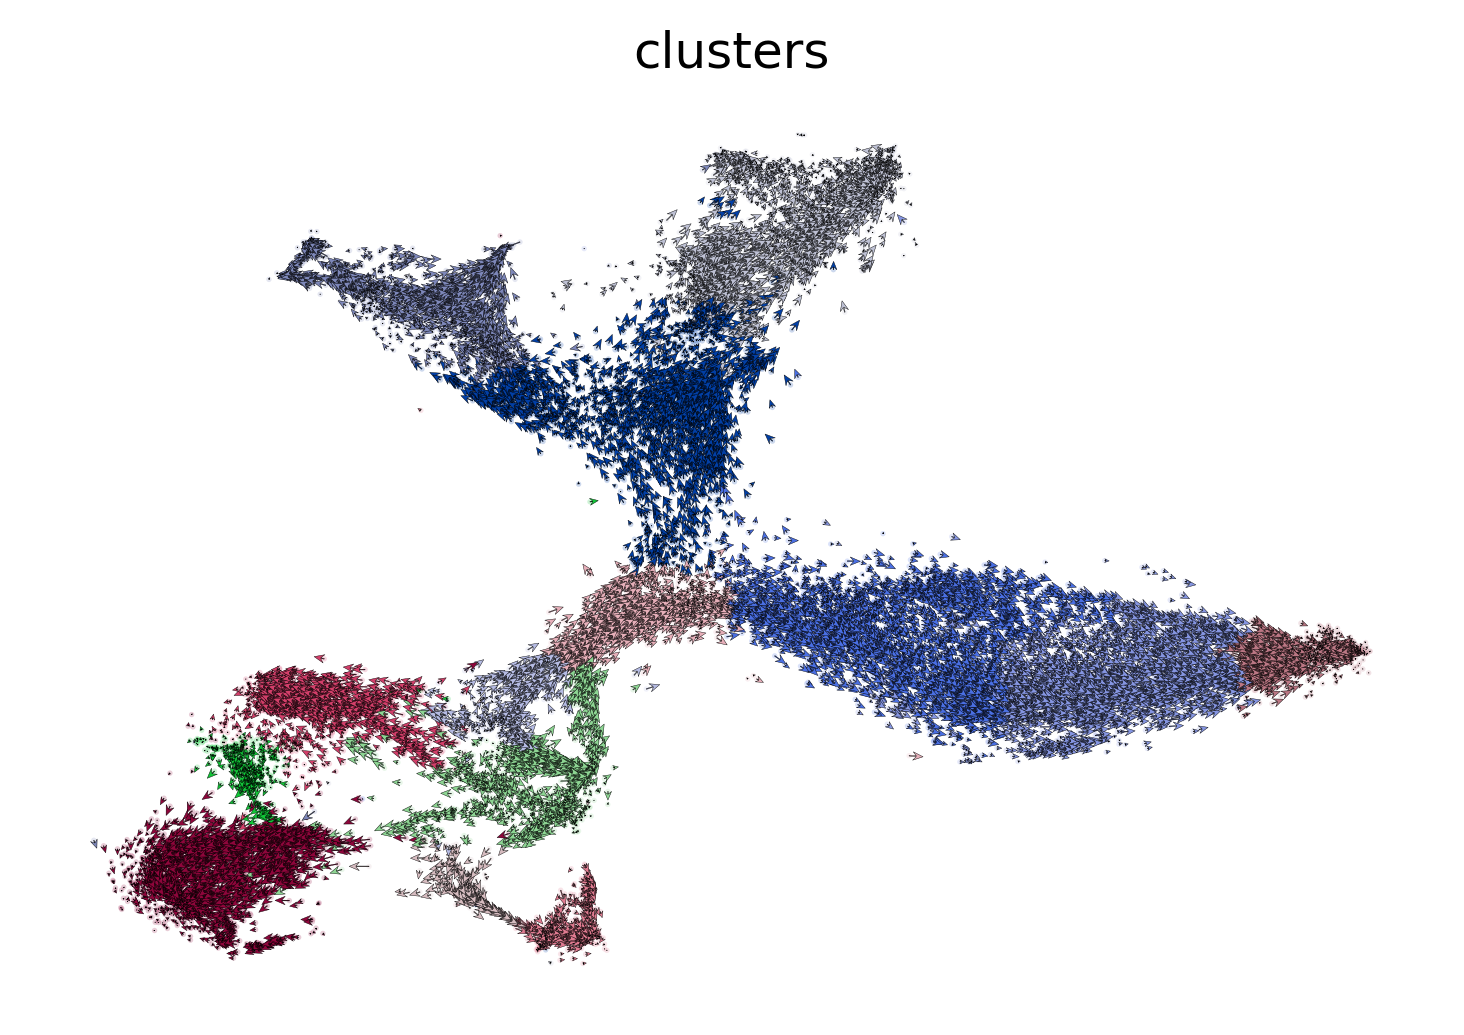

In [9]:
scv.pl.velocity_embedding(
    adata,
    basis="tsne",
    arrow_length=9,
    arrow_size=1.2,
    dpi=150,
)


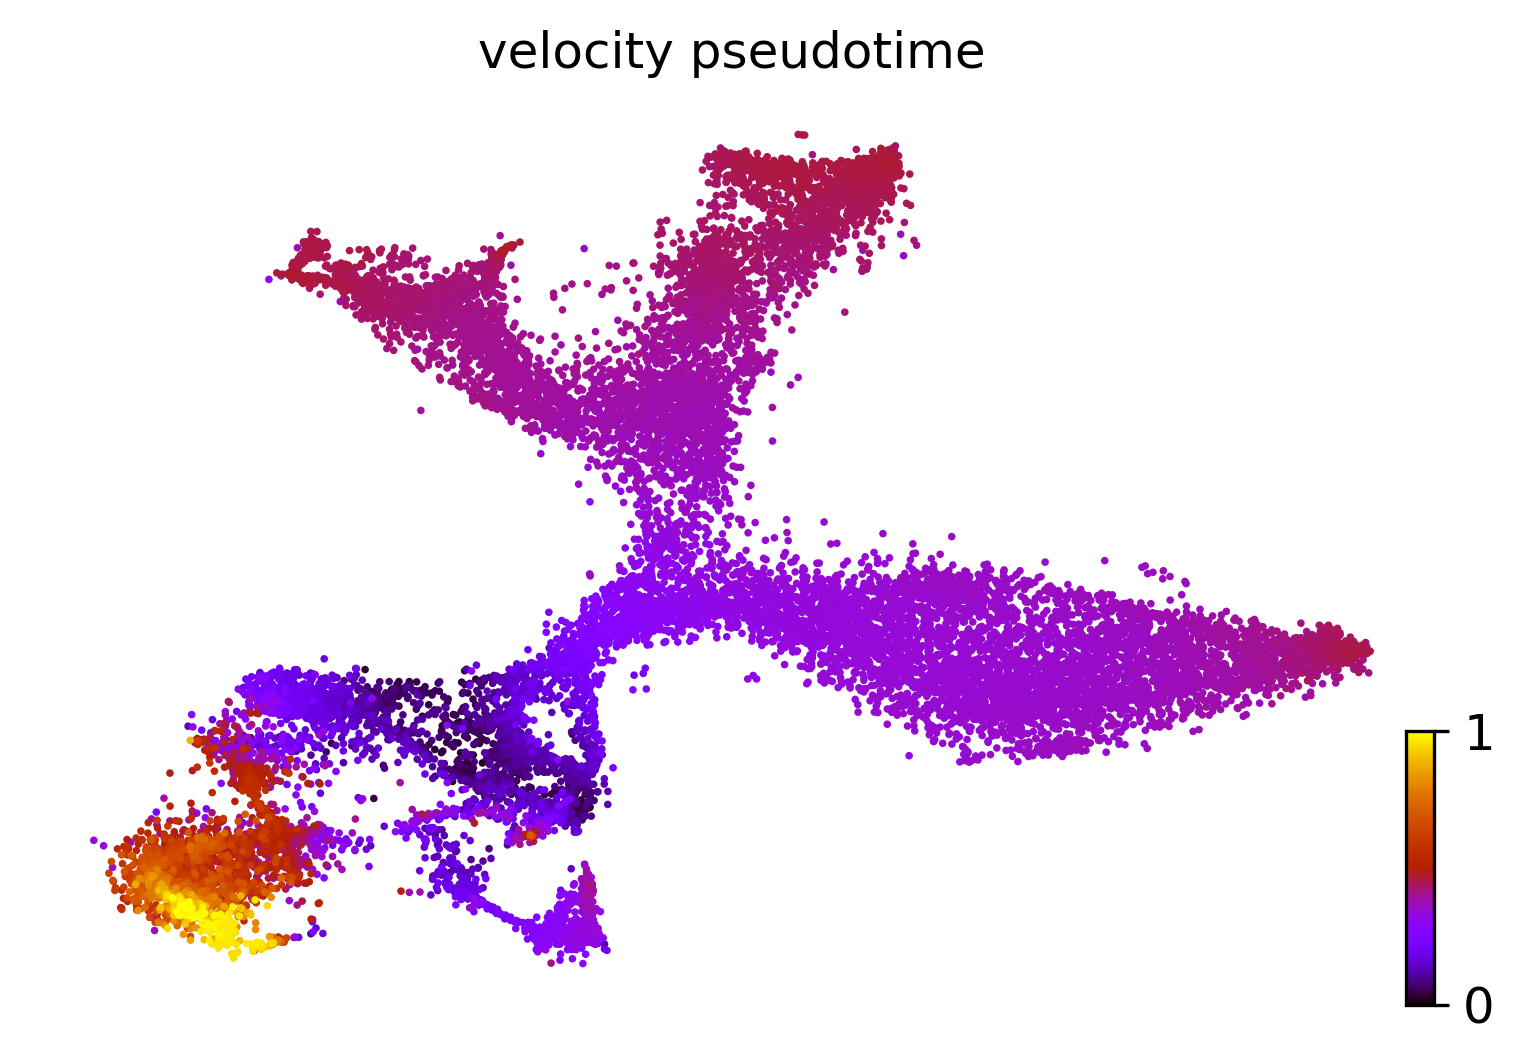

In [12]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


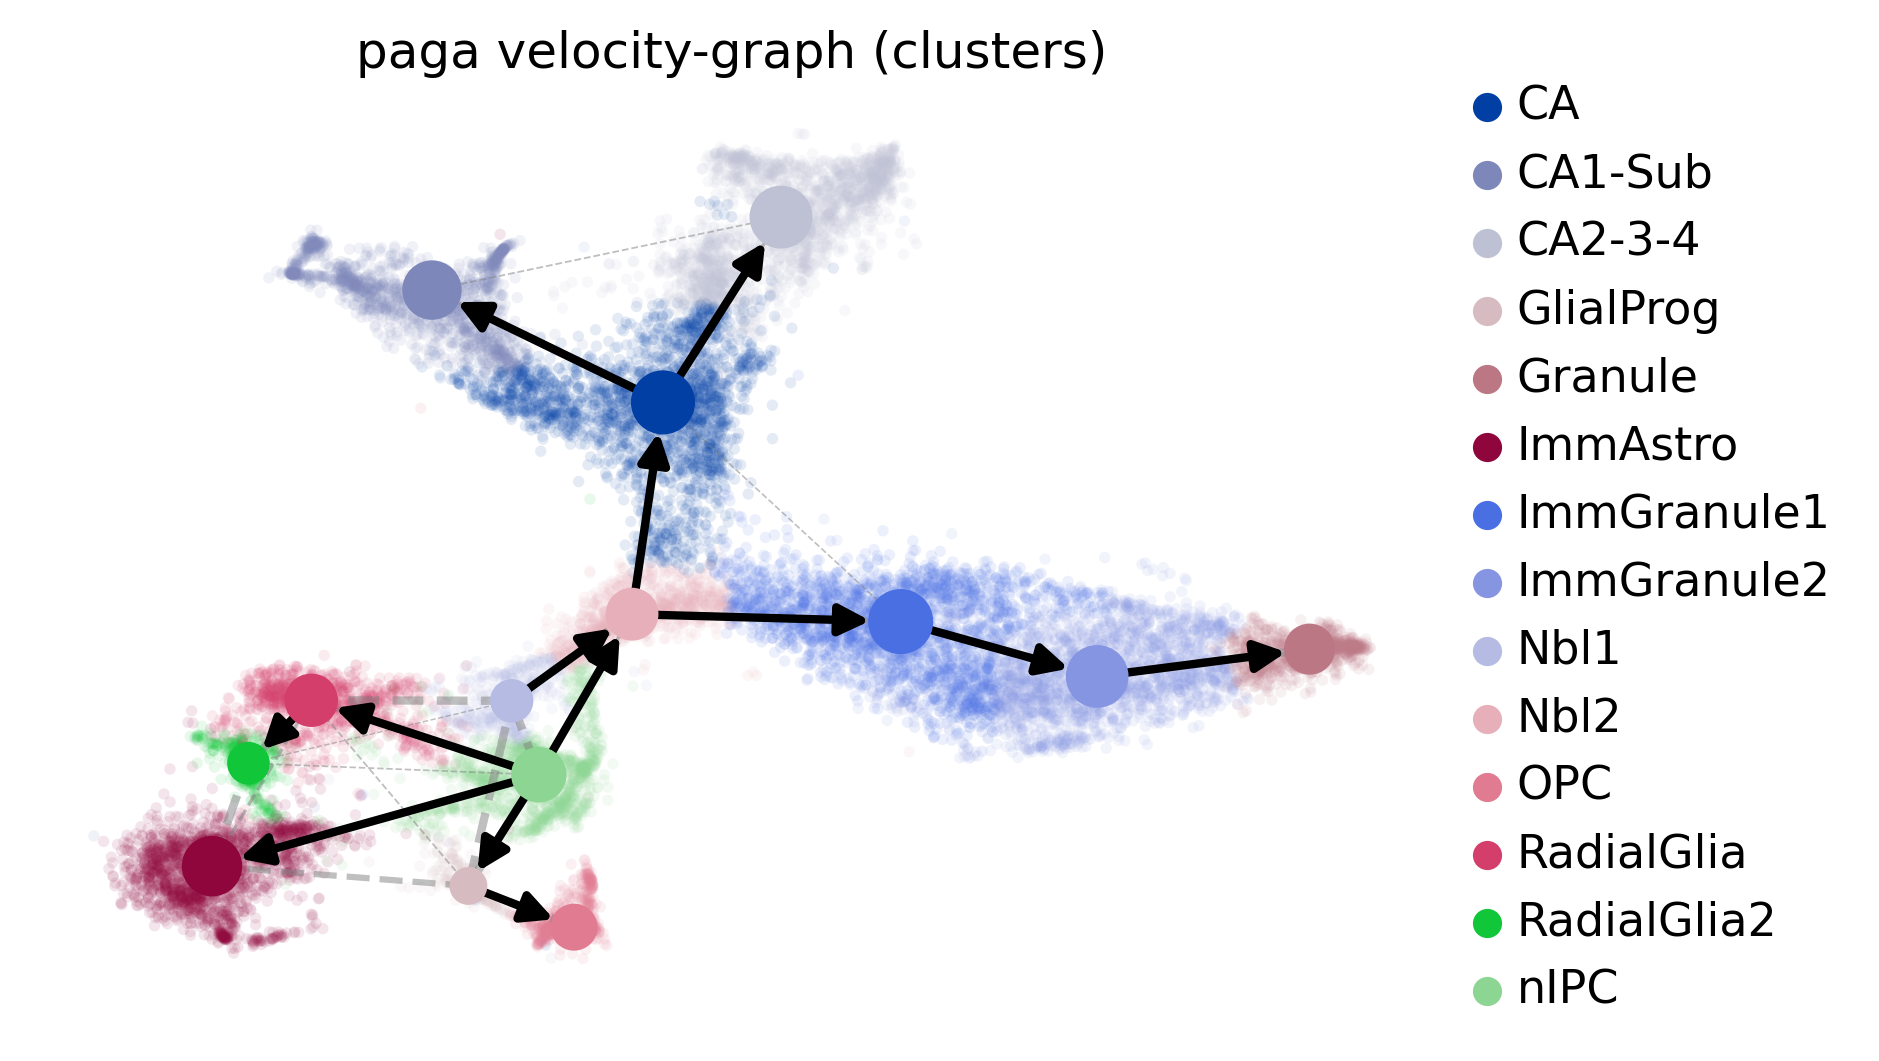

In [13]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [14]:
# save adata for next steps
deepvelo_adata = adata.copy()


# scVelo (dynamical)

In [15]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/1384 [00:00<?, ?gene/s]

    finished (0:10:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:37) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [17]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


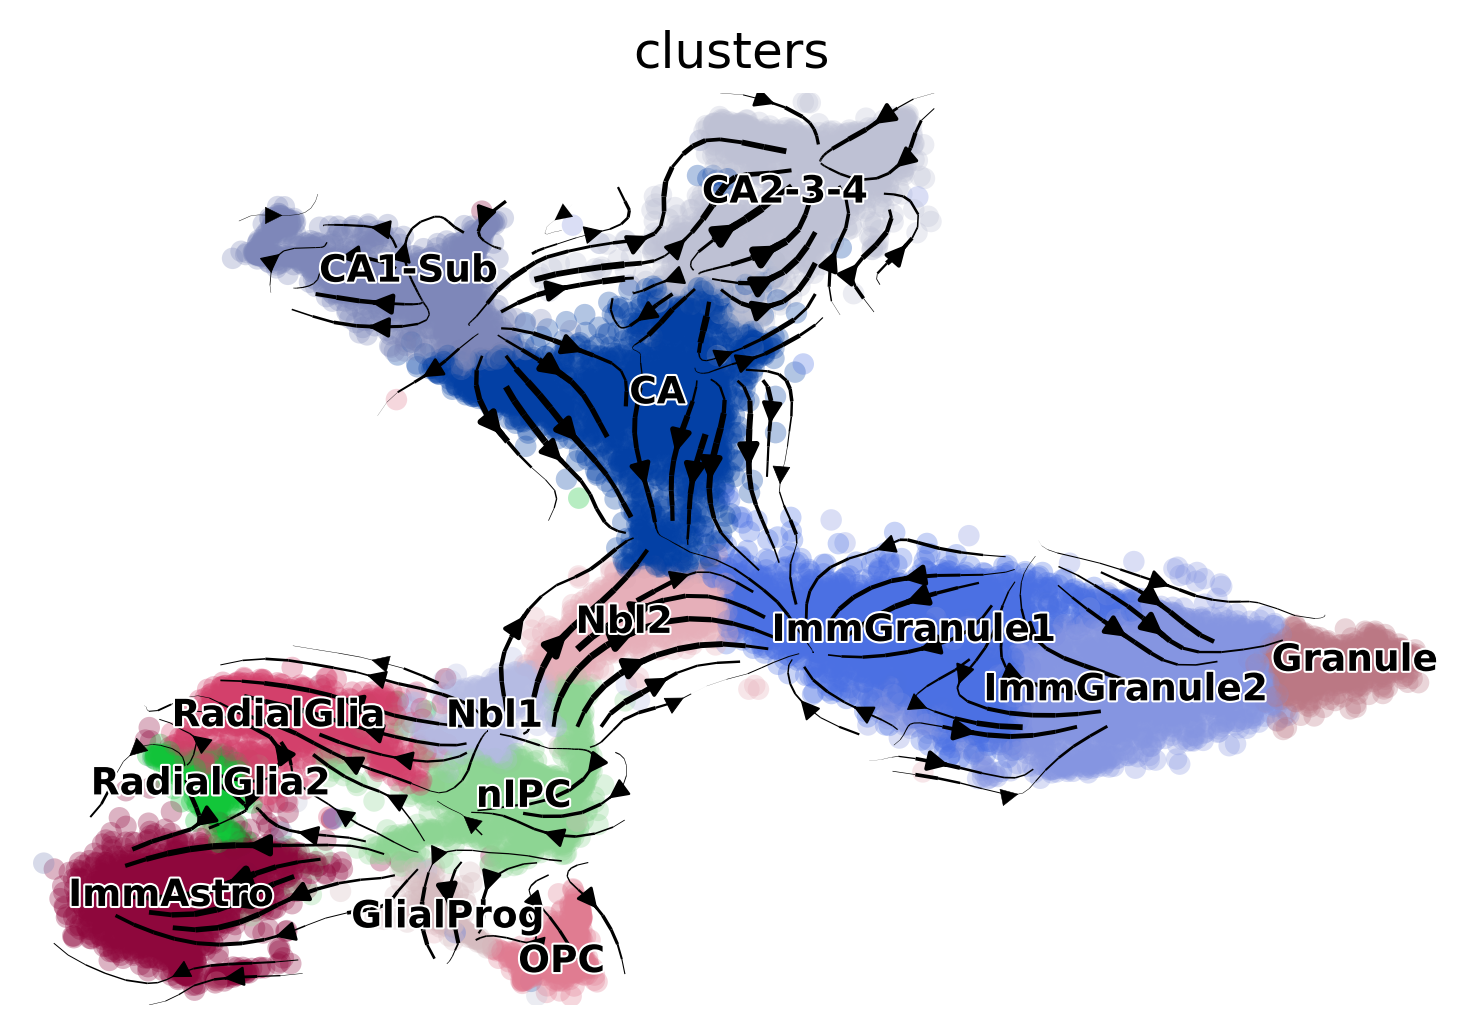

In [18]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


computing terminal states
    identified 3 regions of root cells and 3 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


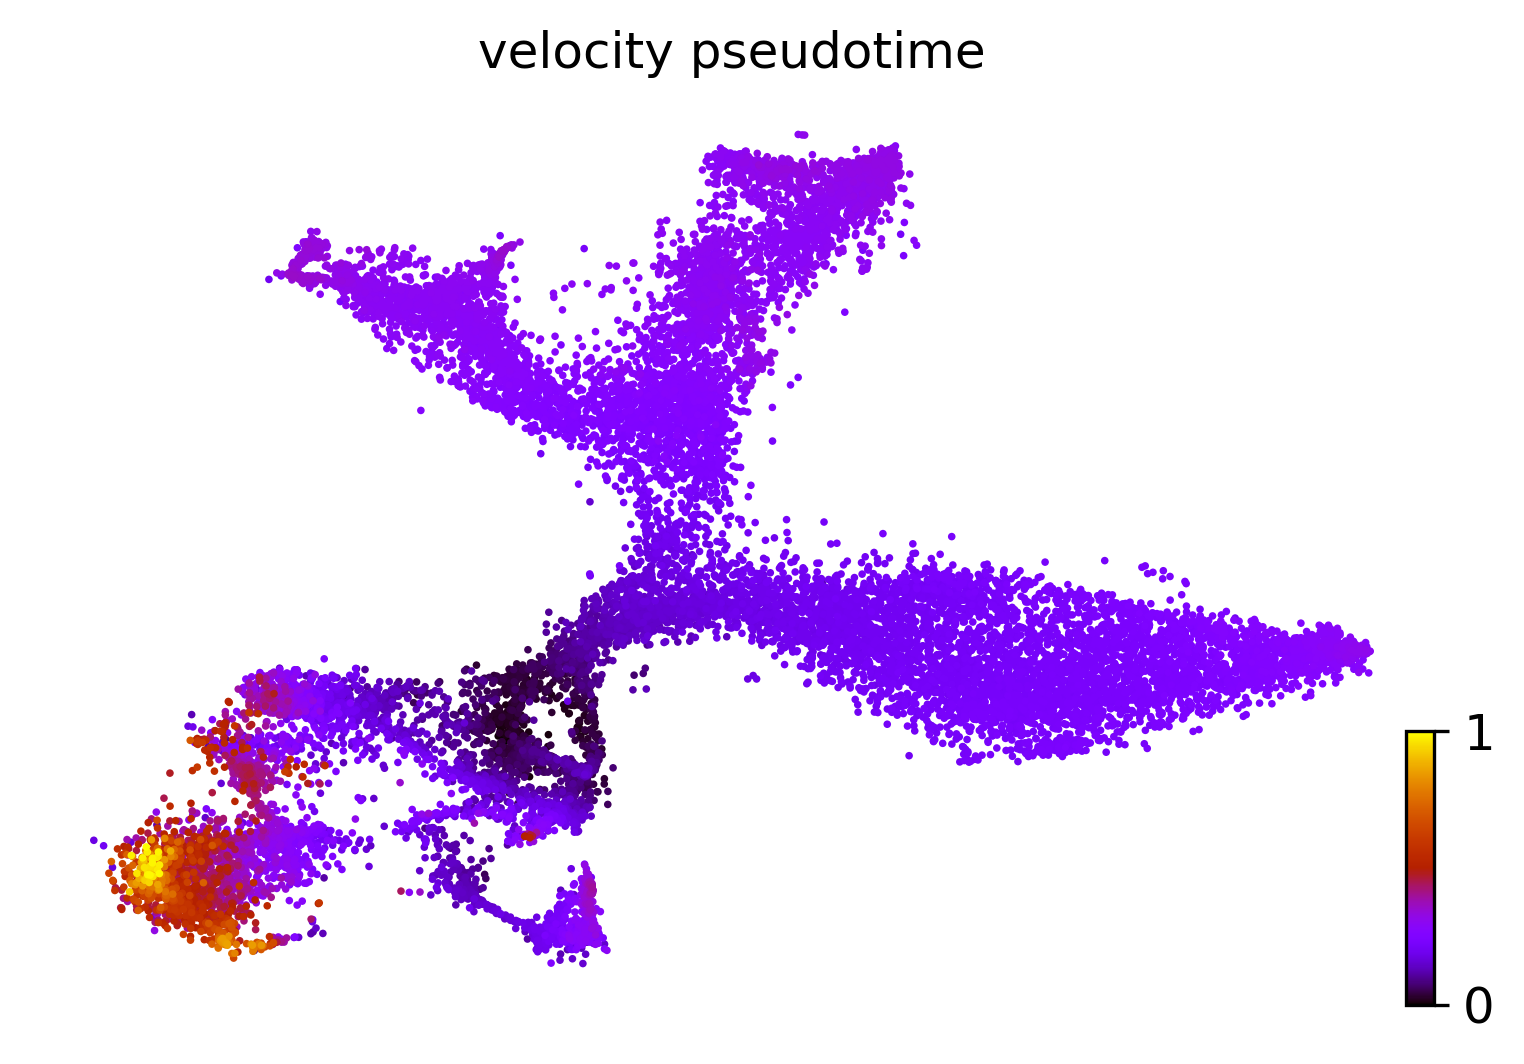

In [19]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


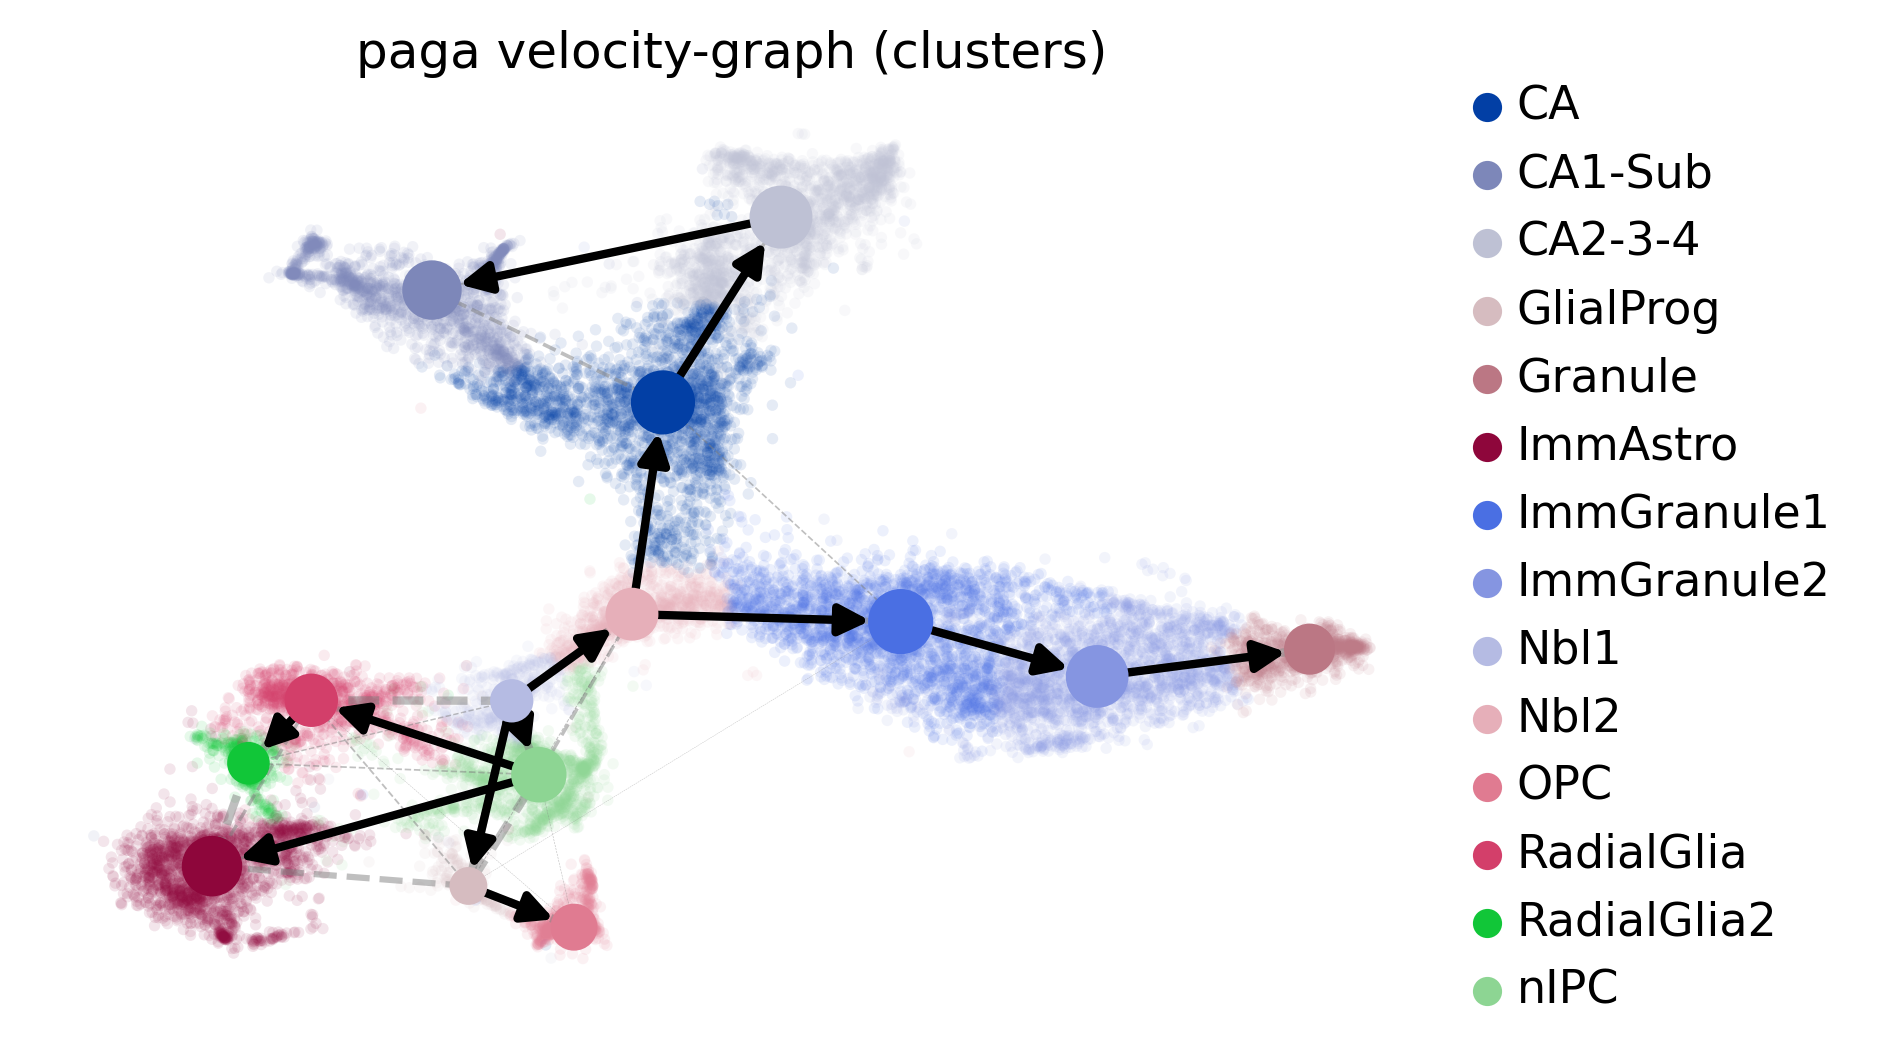

In [20]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [21]:
# save adata for next steps
dynamical_adata = adata.copy()


# Steady-state (stochastic)

In [22]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [23]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


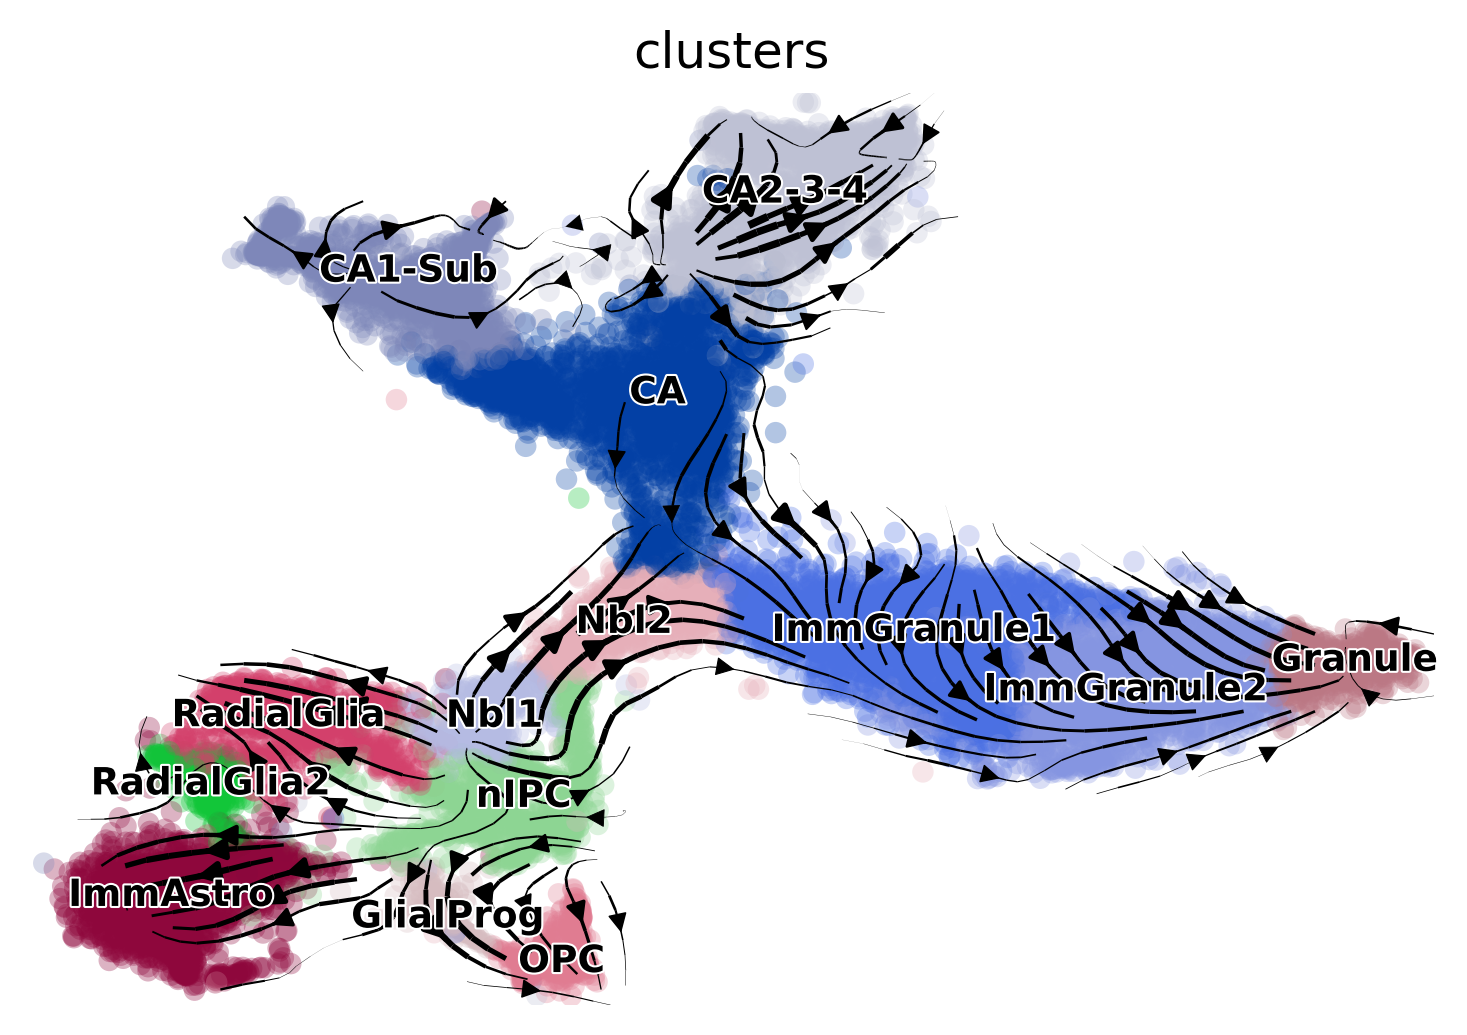

In [24]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


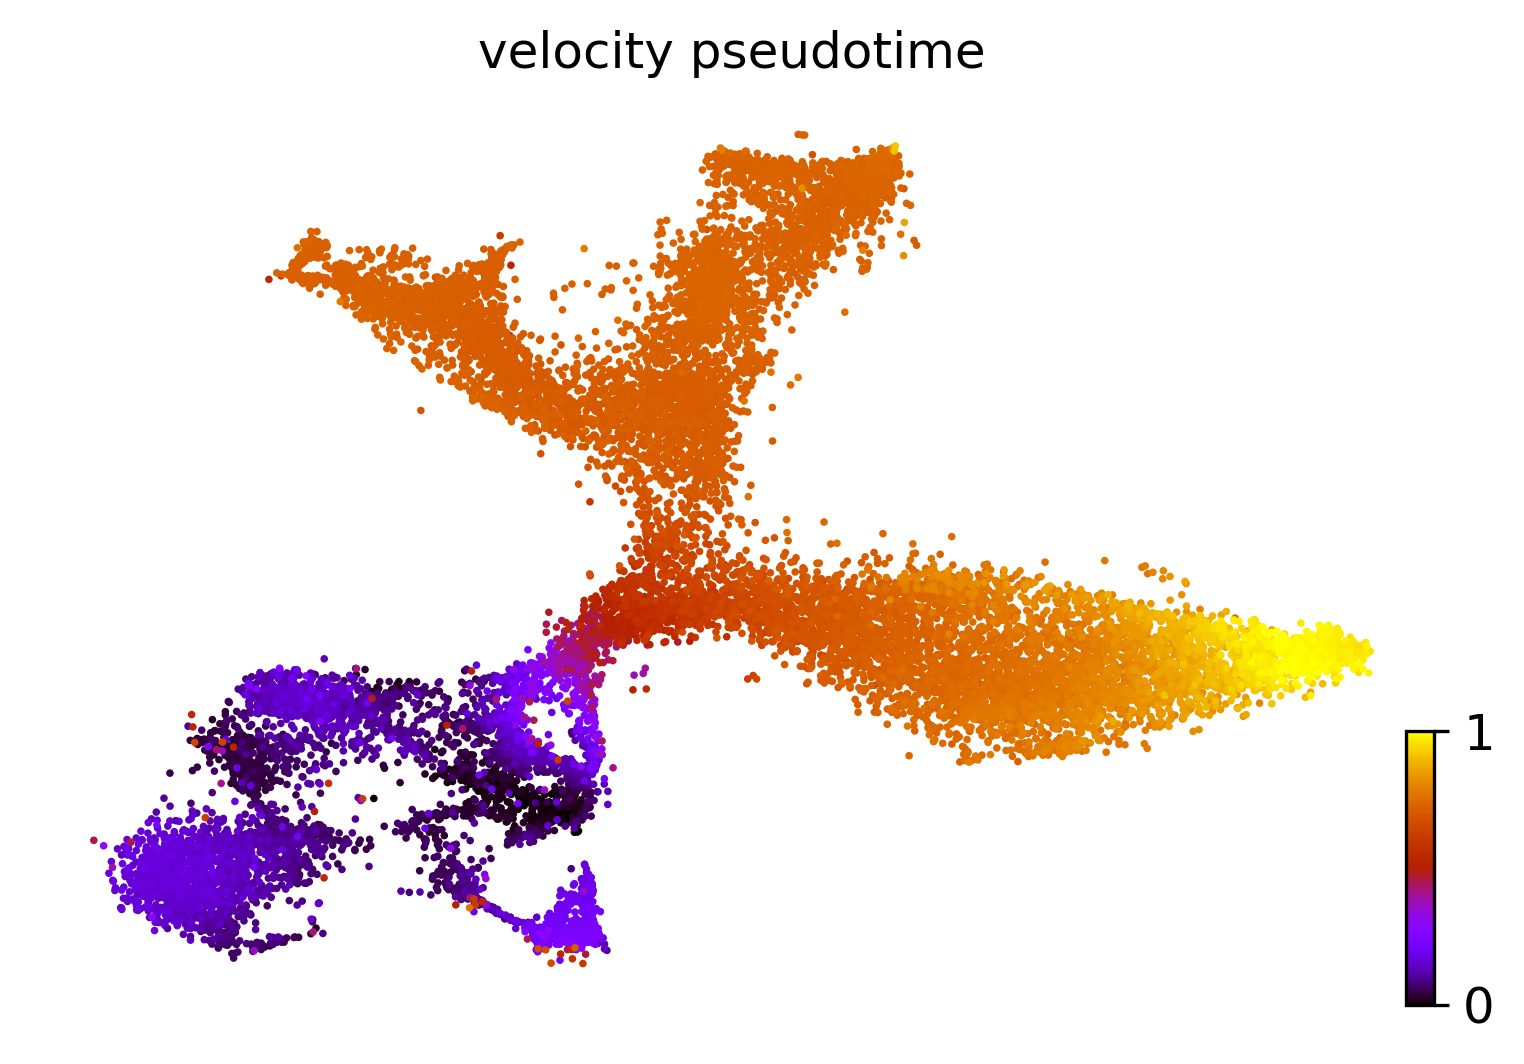

In [25]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


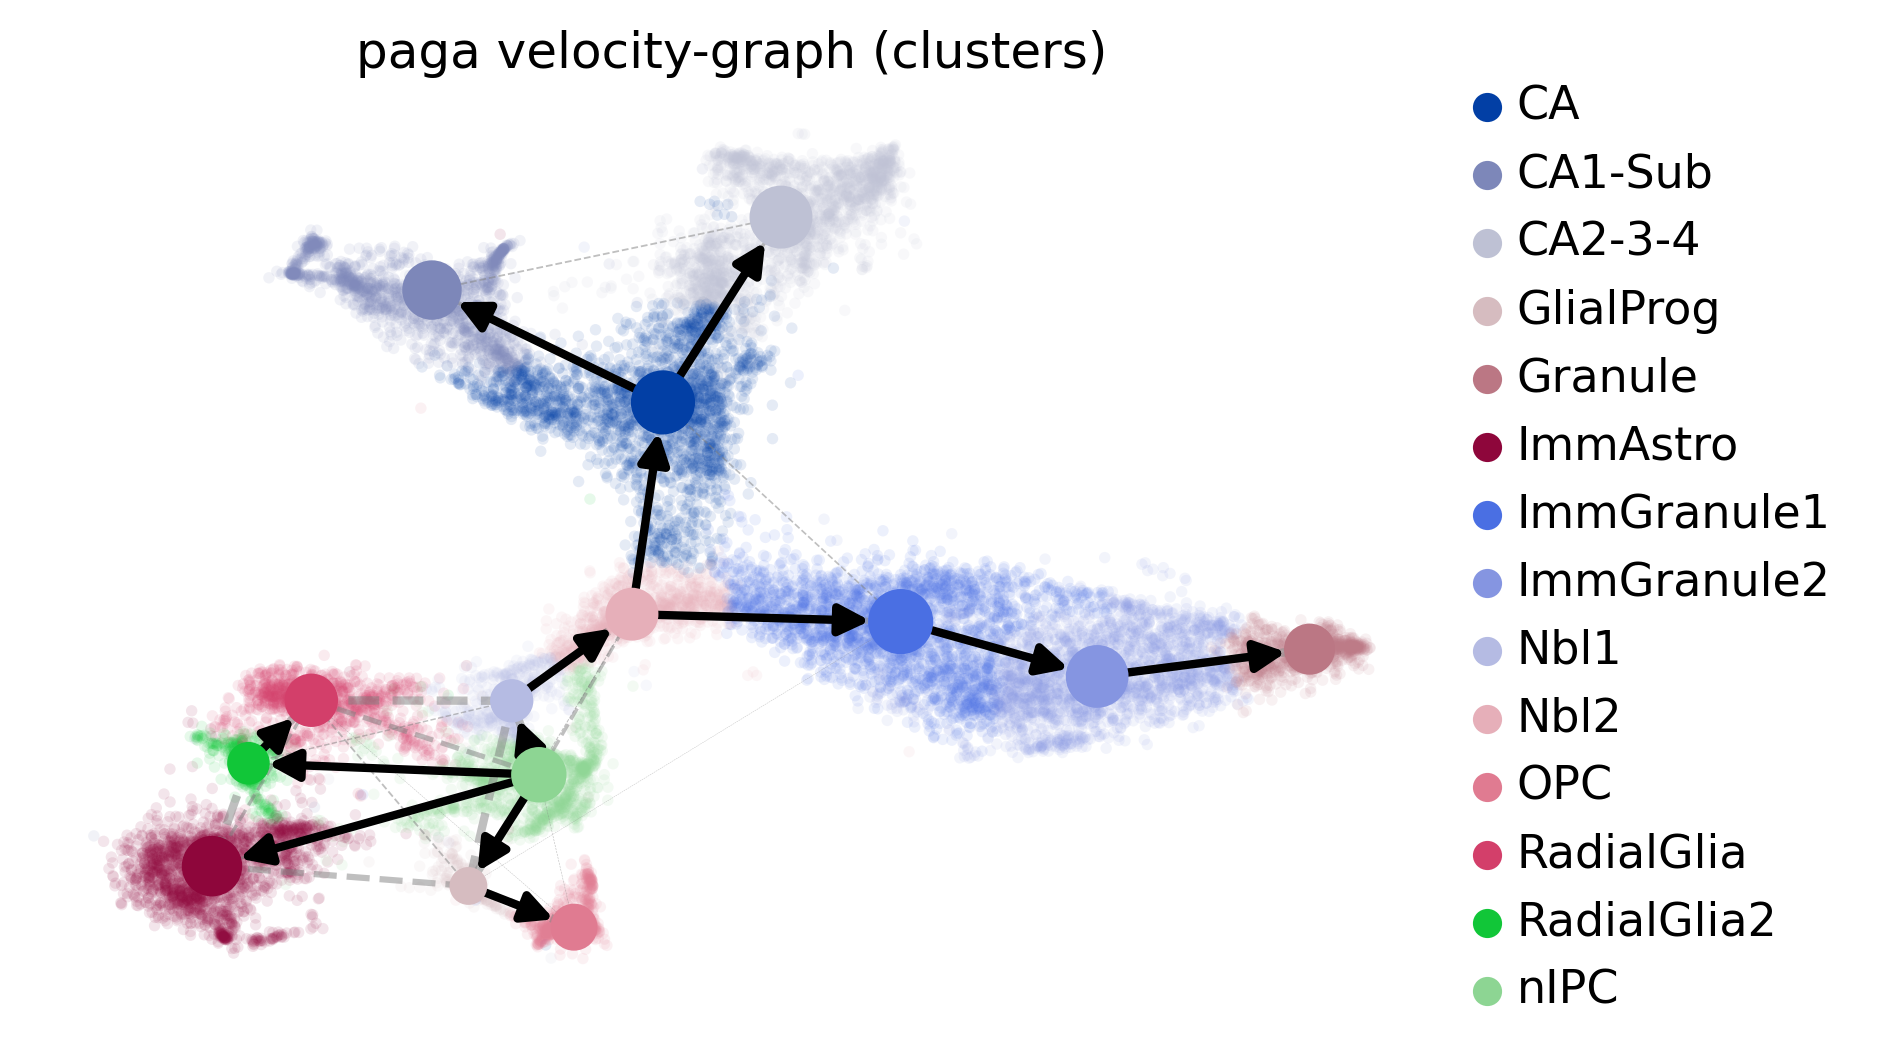

In [26]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [27]:
# save adata for next steps
stochastic_adata = adata.copy()


# Compare consistency score

In [34]:
from deepvelo.utils.confidence import velocity_confidence
from deepvelo.utils.plot import statplot, compare_plot


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9370, std: 0.0336
Dynamical mean score: 0.8567, std: 0.0733
Stochastic mean score: 0.8744, std: 0.0919


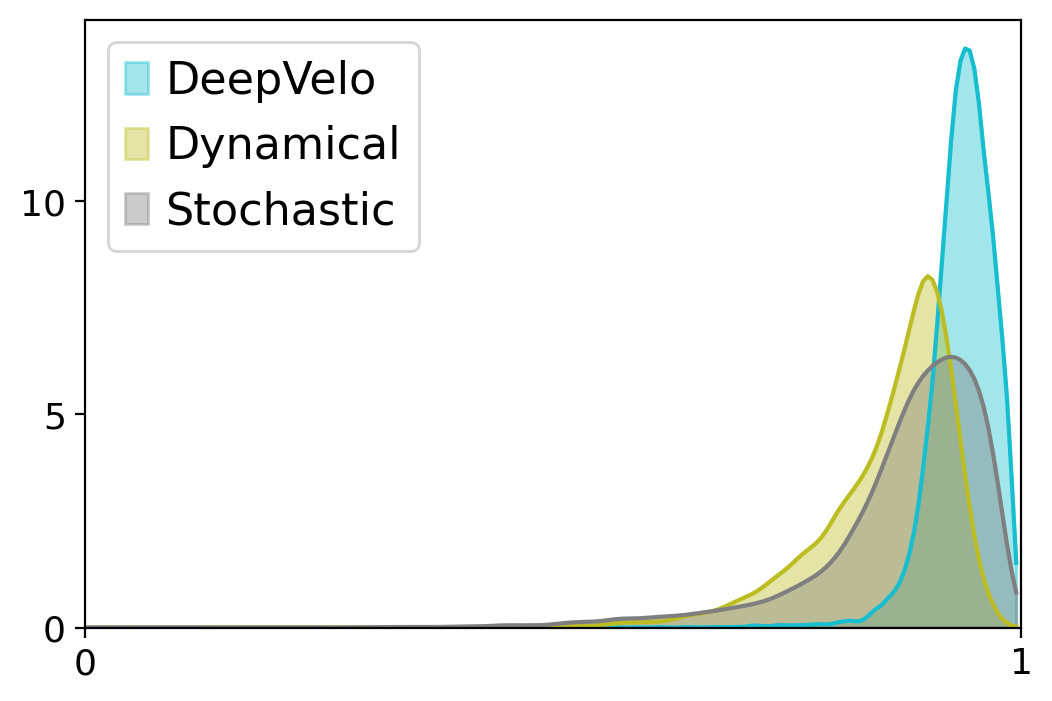

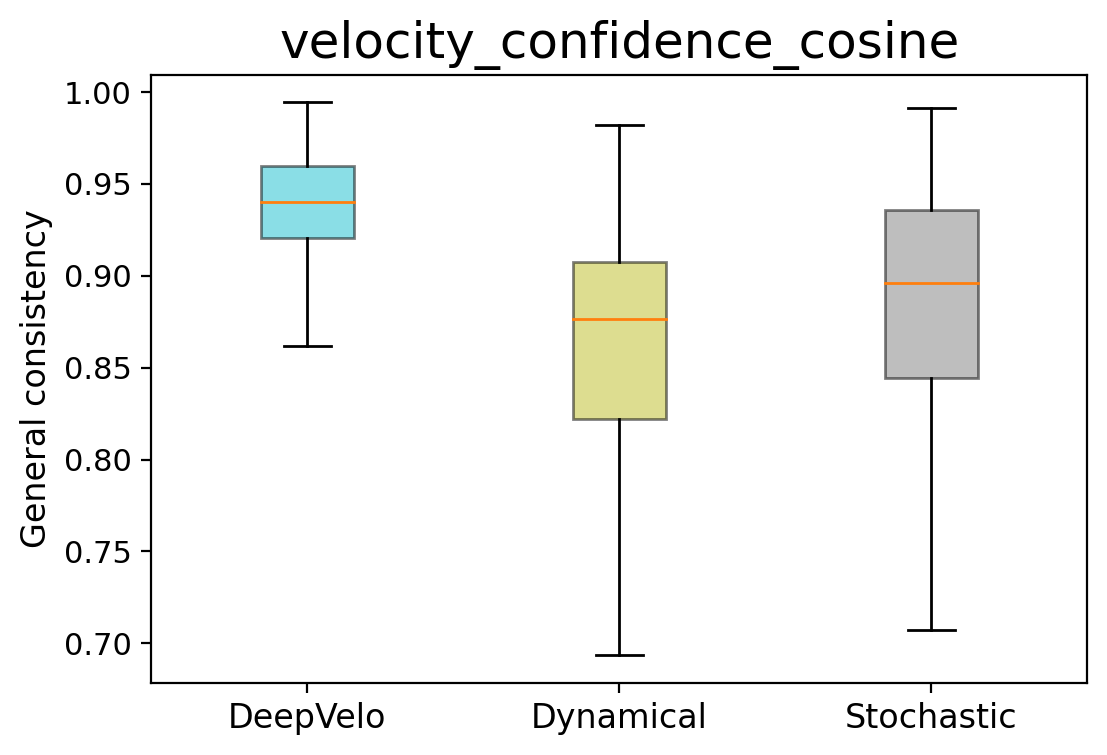

In [35]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
velocity_confidence(stochastic_adata, vkey=vkey, method=method)
compare_plot(
    deepvelo_adata,
    dynamical_adata,
    stochastic_adata,
    labels=["DeepVelo", "Dynamical", "Stochastic"],
    method=method,
)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.7284, std: 0.0992
Dynamical mean score: 0.5891, std: 0.1878
Stochastic mean score: 0.6452, std: 0.1808


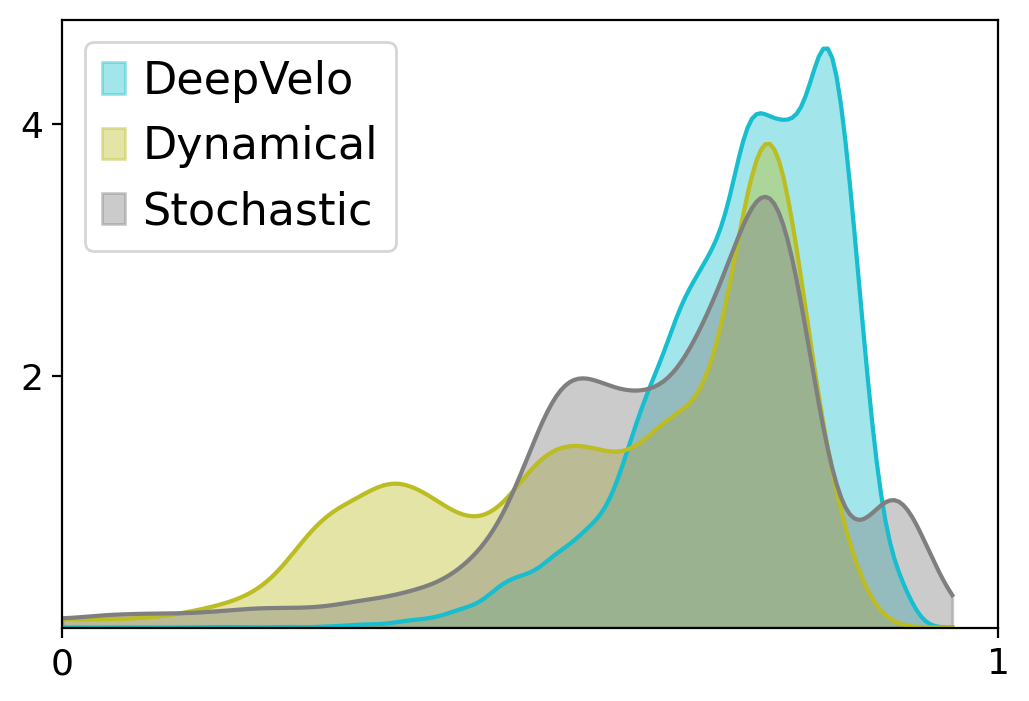

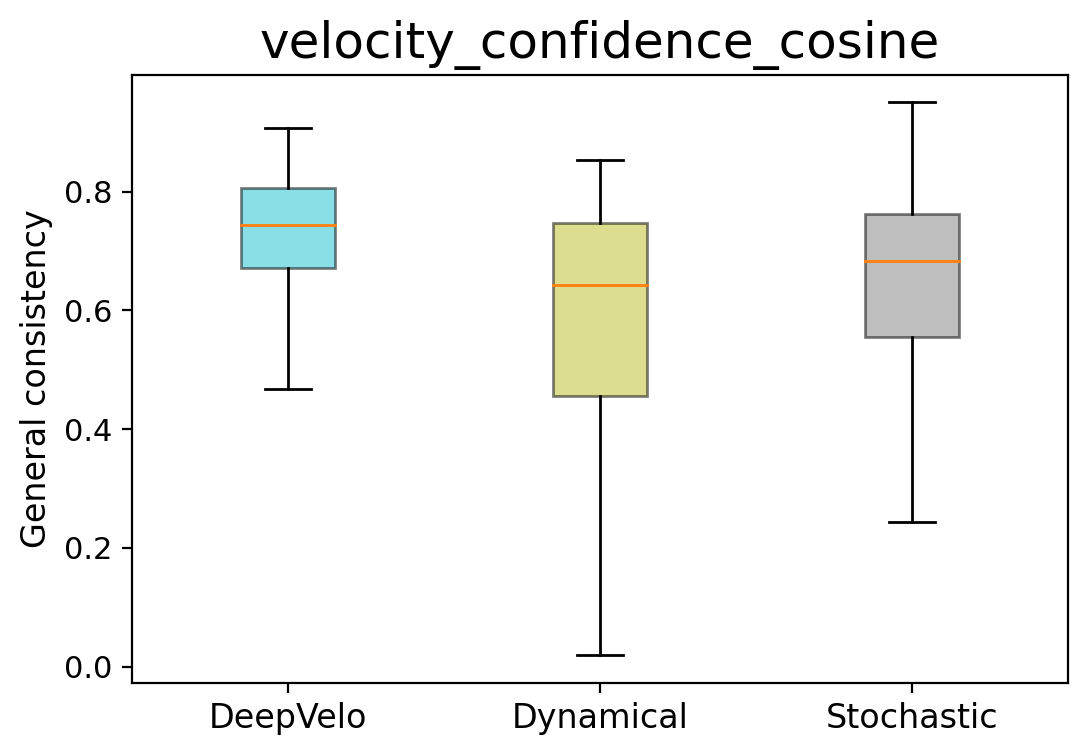

In [33]:
vkey = "velocity"
method = "cosine"
scope_key = "clusters"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(stochastic_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(
    deepvelo_adata,
    dynamical_adata,
    stochastic_adata,
    labels=["DeepVelo", "Dynamical", "Stochastic"],
    method=method,
)
